# If any issues arise during execution, utilize parallel GPU processing, considering that the model has been trained and saved using parallel GPU architecture.

In [1]:
!pip install einops
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for pyspark: filename=pyspark-3.4.2-py2.py3-none-any.whl size=311619854 sha256=434ebb7487d70fbf39bb7b08e996e44151fb78783c3af9f612349ab19c39098b
  Stored in directory: /root/.cache/pip/wheels/c1/1e/45/21d8f2dd514b2c1318a24a9b75427ecbee40ed9abf91917256
Successfully built pyspark


In [2]:
import os
import timm
import cv2
import h5py
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR,ExponentialLR
from torchvision.transforms import Resize, ToTensor
from torch.cuda.amp import autocast, GradScaler
import einops
from einops import repeat, rearrange,einsum
from skimage.transform import resize


from einops.layers.torch import Rearrange
from pyspark.sql import SparkSession

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
gpus = torch.cuda.device_count()

if gpus <= 1:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPU')
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Using {gpus} GPUs')


Using 1 GPU


In [5]:
MIX = False
if MIX:
    scaler = GradScaler()
    print('Mixed precision enabled')
else:
    print('Using full precision')

Using full precision


In [6]:
dfs = []
parquet_file = pq.ParquetFile('/kaggle/input/task-3a/Task_3a/top_gun_opendata_3.parquet')
total_rows = parquet_file.metadata.num_rows
chunk_size = 8
for i in range(0,total_rows,chunk_size):
    chunk = parquet_file.read_row_group(i)
    df = chunk.to_pandas()
    condition = (df['m'] > 0) & (df['m'] < 256) & (df['pt'] > 320) & (df['pt'] < 1600) & (df['ieta'] < 80.25)
    filtered_df = df[condition]
    if not filtered_df.empty:
        dfs.append(filtered_df)

dataset = pd.concat(dfs, ignore_index=True)
print('Dataset Length:', len(dataset))

Dataset Length: 7676


In [7]:
dataset.describe()

,m,iphi,pt,ieta
count,7676.000000,7676.000000,7676.000000,7676.000000
mean,170.188106,35.123372,699.564382,27.449844
std,49.473223,20.743823,173.854311,8.596656
min,85.339424,0.000000,400.474030,12.000000
25%,127.098766,17.000000,547.183167,20.000000
50%,171.119751,35.000000,701.326172,27.000000
75%,213.003334,53.000000,850.035019,35.000000
max,255.973297,71.000000,999.966858,43.000000


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7676 entries, 0 to 7675
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X_jet   7676 non-null   object 
 1   m       7676 non-null   float64
 2   iphi    7676 non-null   float64
 3   pt      7676 non-null   float64
 4   ieta    7676 non-null   float64
dtypes: float64(4), object(1)
memory usage: 300.0+ KB


In [9]:
total_r = dataset["X_jet"].shape[0]
total_r

7676

In [10]:
dataset["X_jet"][0].shape

(8,)

In [11]:
dataset["X_jet"][0][0].shape

(125,)

In [12]:
dataset["X_jet"][0][0][0].shape

(125,)

In [13]:
def to_array(data):
    arr = []
    for i in range(0, 4):
        a = np.stack(np.stack(data)[i], axis=-1)
        arr.append(a)
    arr = np.array(arr)
    arr = arr.reshape((125, 125, 4))
    return arr


In [14]:
dataset["X_jet"] = dataset["X_jet"].apply(to_array)

In [15]:
dataset["X_jet"][0].shape

(125, 125, 4)

In [16]:
y = dataset["m"]
scaler = StandardScaler()
dataset["m"] = scaler.fit_transform(np.array(y).reshape(-1, 1))

X_jet = np.stack(dataset['X_jet'].apply(np.concatenate).values).reshape(-1,125,125,4)
mean = np.mean(X_jet, axis=(0, 1, 2))
std = np.std(X_jet, axis=(0, 1, 2))
X_jet = (X_jet-mean)/std

for i in range(len(X_jet)):
    dataset["X_jet"][i] = X_jet[i]
    
del X_jet

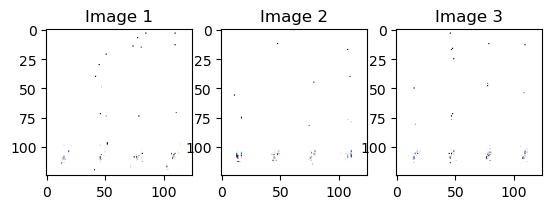

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3)
for i, ax in enumerate(axes.flatten()):
    image = dataset['X_jet'][i][:,:,:]
    ax.imshow(image)
    ax.set_title(f'Image {i+1}')

plt.show()

In [18]:
train_df, val_df = train_test_split(dataset, test_size=0.2, random_state=42)

In [19]:
class CFG:
    model_name = 'DeepVit'
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 25
    random_state = 42
    weight_decay = 1e-4

In [21]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.4):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.dropout = nn.Dropout(dropout)

        self.reattn_weights = nn.Parameter(torch.randn(heads, heads))

        self.reattn_norm = nn.Sequential(
            Rearrange('b h i j -> b i j h'),
            nn.LayerNorm(heads),
            Rearrange('b i j h -> b h i j')
        )

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        # attention
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        attn = self.dropout(attn)

        # re-attention
        attn = torch.einsum('bhij,hg->bgij', attn, self.reattn_weights)

        attn = self.reattn_norm(attn)

        # aggregate and out

        out = torch.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class DeepViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=4, dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        assert channels == 4, 'Number of input channels must be 4 for the given input format.'

        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)


In [22]:
model = DeepViT(
    image_size = 125,
    patch_size = 25,
    num_classes = 1,
    dim = 1024,
    depth = 6,
    heads = 8,
    channels = 4,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [23]:
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
scheduler = ExponentialLR(optimizer, gamma=0.4) 

In [24]:
X_jets = np.stack(train_df['X_jet'].apply(np.concatenate).values)
X_train = torch.tensor(X_jets, dtype=torch.float32).view(-1, 125,125, 4)
y_train = pd.to_numeric(train_df['m'])
y_train = torch.tensor(y_train.values, dtype=torch.float32)

X_jets = np.stack(val_df['X_jet'].apply(np.concatenate).values)
X_val = torch.tensor(X_jets, dtype=torch.float32).view(-1,125, 125, 4)

y_val = pd.to_numeric(val_df['m'])
y_val = torch.tensor(y_val.values, dtype=torch.float32)


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=True)

In [25]:
next(iter(train_loader))[0].shape

torch.Size([32, 125, 125, 4])

In [26]:
train_losses = []
val_losses = []
mae_losses = []
mre_losses = []

best_val_loss = float('inf')
best_mre = float('inf')
best_val_loss_model = None
best_mre_model = None

for epoch in range(CFG.num_epochs):
    model.train()
    train_loss = 0.0
    train_preds_list = []

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{CFG.num_epochs} (Training)'):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 3, 1, 2)
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds_list.append(outputs.detach().cpu().numpy())

    train_loss /= len(train_loader)
    train_preds = np.concatenate(train_preds_list)

    model.eval()
    val_loss = 0.0
    mae_loss = 0.0
    mre_loss = 0.0
    val_preds_list = []

    for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch + 1}/{CFG.num_epochs} (Validation)'):
        inputs = inputs.permute(0, 3, 1, 2)
        val_inputs, val_labels = inputs.to(device), labels.to(device)
        val_outputs = model(val_inputs)
        val_loss += criterion(val_outputs, val_labels).item()
        val_preds_list.append(val_outputs.detach().cpu().numpy())
        mae_loss += torch.abs(val_outputs - val_labels).sum().item()
        absolute_errors = torch.abs(val_outputs - val_labels)
        mre_loss += (absolute_errors / (torch.abs(val_labels) + 1e-6)).sum().item()

    val_loss /= len(val_loader)
    mae_loss /= len(val_loader.dataset)
    mre_loss /= len(val_loader.dataset)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    mae_losses.append(mae_loss)
    mre_losses.append(mre_loss)
  
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_loss_model = model.state_dict()

    if mre_loss < best_mre:
        best_mre = mre_loss
        best_mre_model = model.state_dict()
    scheduler.step()
    print(f"Epoch {epoch + 1}/{CFG.num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, MAE: {mae_loss:.4f}, MRE: {mre_loss:.4f}")
    
torch.save(best_val_loss_model, 'best_model_val_loss.pth')
torch.save(best_mre_model, 'best_model_mre.pth')
print("Model saved successfully.")
print("Finished training")

Epoch 1/25 (Validation):   0%|          | 0/48 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.90it/s]


Epoch 1/25, Train Loss: 2.2727, Val Loss: 1.0233, MAE: 28.0486, MRE: 47.1953


Epoch 2/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.99it/s]


Epoch 2/25, Train Loss: 0.9624, Val Loss: 1.0453, MAE: 28.1923, MRE: 47.9806


Epoch 3/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.09it/s]


Epoch 3/25, Train Loss: 0.8325, Val Loss: 1.0723, MAE: 28.4128, MRE: 51.3511


Epoch 4/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.47it/s]


Epoch 4/25, Train Loss: 0.6559, Val Loss: 1.1928, MAE: 29.4940, MRE: 70.3619


Epoch 5/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.58it/s]


Epoch 5/25, Train Loss: 0.4919, Val Loss: 1.2771, MAE: 30.2370, MRE: 75.9034


Epoch 6/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.24it/s]


Epoch 6/25, Train Loss: 0.4208, Val Loss: 1.3267, MAE: 30.6768, MRE: 83.3055


Epoch 7/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.94it/s]


Epoch 7/25, Train Loss: 0.3875, Val Loss: 1.3099, MAE: 30.5303, MRE: 79.0555


Epoch 8/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.93it/s]


Epoch 8/25, Train Loss: 0.3770, Val Loss: 1.3118, MAE: 30.5327, MRE: 86.5693


Epoch 9/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.34it/s]


Epoch 9/25, Train Loss: 0.3696, Val Loss: 1.3201, MAE: 30.6160, MRE: 85.9159


Epoch 10/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.31it/s]


Epoch 10/25, Train Loss: 0.3722, Val Loss: 1.3240, MAE: 30.6050, MRE: 84.9838


Epoch 11/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.80it/s]


Epoch 11/25, Train Loss: 0.3688, Val Loss: 1.3290, MAE: 30.7185, MRE: 81.2900


Epoch 12/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.19it/s]


Epoch 12/25, Train Loss: 0.3659, Val Loss: 1.3232, MAE: 30.6528, MRE: 80.2769


Epoch 13/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.82it/s]


Epoch 13/25, Train Loss: 0.3606, Val Loss: 1.3180, MAE: 30.5767, MRE: 84.1643


Epoch 14/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.17it/s]


Epoch 14/25, Train Loss: 0.3643, Val Loss: 1.3287, MAE: 30.7017, MRE: 81.8052


Epoch 15/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 55.96it/s]


Epoch 15/25, Train Loss: 0.3668, Val Loss: 1.3260, MAE: 30.7074, MRE: 83.2996


Epoch 16/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.48it/s]


Epoch 16/25, Train Loss: 0.3623, Val Loss: 1.3197, MAE: 30.6319, MRE: 82.2408


Epoch 17/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.95it/s]


Epoch 17/25, Train Loss: 0.3660, Val Loss: 1.3352, MAE: 30.7858, MRE: 87.4355


Epoch 18/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.40it/s]


Epoch 18/25, Train Loss: 0.3735, Val Loss: 1.3200, MAE: 30.6022, MRE: 83.0707


Epoch 19/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.38it/s]


Epoch 19/25, Train Loss: 0.3686, Val Loss: 1.3215, MAE: 30.6498, MRE: 84.9735


Epoch 20/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.03it/s]


Epoch 20/25, Train Loss: 0.3692, Val Loss: 1.3275, MAE: 30.7291, MRE: 84.2596


Epoch 21/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.47it/s]


Epoch 21/25, Train Loss: 0.3688, Val Loss: 1.3243, MAE: 30.6742, MRE: 84.2570


Epoch 22/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 57.03it/s]


Epoch 22/25, Train Loss: 0.3700, Val Loss: 1.3170, MAE: 30.5768, MRE: 83.2744


Epoch 23/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.56it/s]


Epoch 23/25, Train Loss: 0.3668, Val Loss: 1.3392, MAE: 30.8101, MRE: 83.2645


Epoch 24/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 56.60it/s]


Epoch 24/25, Train Loss: 0.3675, Val Loss: 1.3288, MAE: 30.6983, MRE: 85.3697


Epoch 25/25 (Validation): 100%|██████████| 48/48 [00:00<00:00, 55.69it/s]


Epoch 25/25, Train Loss: 0.3724, Val Loss: 1.3285, MAE: 30.6843, MRE: 82.9212
Model saved successfully.
Finished training


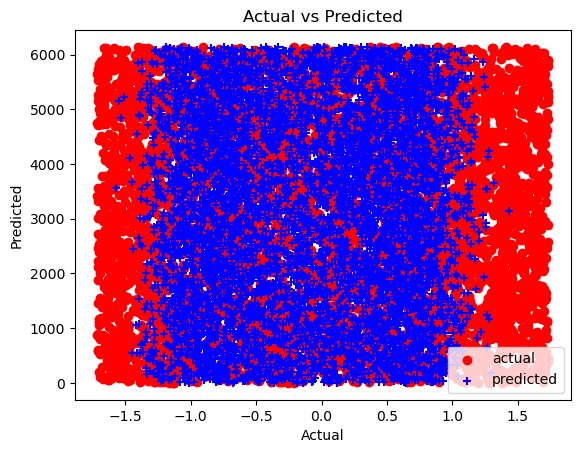

In [27]:
checkpoint = torch.load("/kaggle/working/best_model_val_loss.pth")
model = DeepViT(
    image_size = 125,
    patch_size = 25,
    num_classes = 1,
    dim = 1024,
    depth = 6,
    heads = 8,
    channels = 4,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model.load_state_dict(checkpoint)
model = model.to(device)
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        output = model(data)
        y_true.extend(target.cpu().numpy().tolist())
        y_pred.extend(output.cpu().numpy().tolist())

plt.scatter(y_true, range(len(train_dataset)), color='red', label='actual')
plt.scatter(y_pred, range(len(train_dataset)), color='blue', marker='+', label="predicted")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


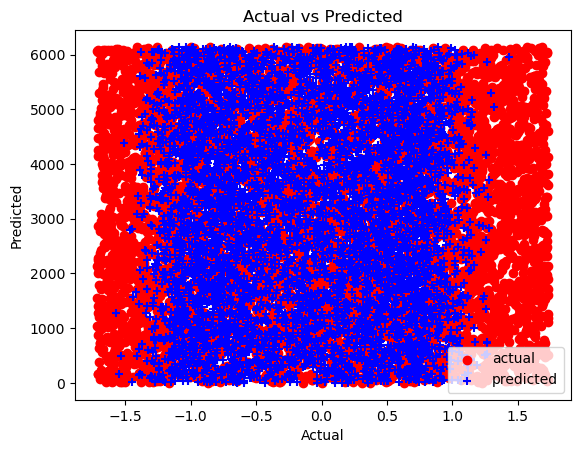

In [29]:
checkpoint = torch.load("/kaggle/working/best_model_mre.pth")
modell = DeepViT(
    image_size = 125,
    patch_size = 25,
    num_classes = 1,
    dim = 1024,
    depth = 6,
    heads = 8,
    channels = 4,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

if torch.cuda.device_count() > 1:
    modell = nn.DataParallel(modell)
modell.load_state_dict(checkpoint)
modell = modell.to(device)
modell.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        output = modell(data)
        y_true.extend(target.cpu().numpy().tolist())
        y_pred.extend(output.cpu().numpy().tolist())

plt.scatter(y_true, range(len(train_dataset)), color='red', label='actual')
plt.scatter(y_pred, range(len(train_dataset)), color='blue', marker='+', label="predicted")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()


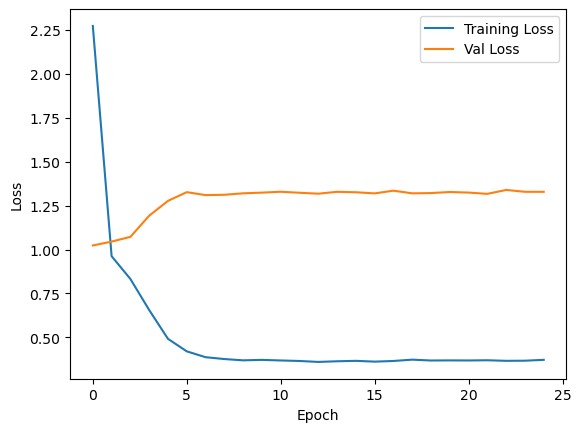

In [31]:
plt.plot( train_losses, label='Training Loss')
plt.plot( val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

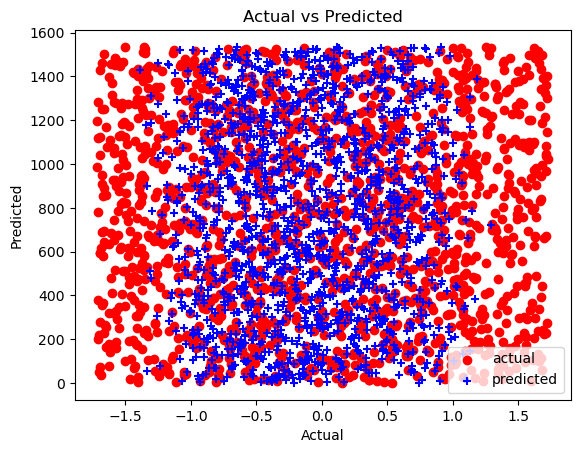

In [32]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        output = model(data)
        
        y_true.extend(target.cpu().numpy().tolist())
        y_pred.extend(output.cpu().numpy().tolist())

plt.scatter(y_true, range(len(val_dataset)), color='red', label='actual')
plt.scatter(y_pred, range(len(val_dataset)), color='blue', marker='+', label="predicted")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.title('Actual vs Predicted')
plt.show()
